In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import poisson, chi2, expon, binom
from scipy.optimize import curve_fit, minimize
from functools import partial 
from scipy.integrate import quad
from scipy.special import gammaln
import pandas as pd
import time
import random as rnd
from tqdm import tqdm
import math 
import sympy 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation



colors=['darkcyan','indianred','#fb8b24','#392f5a',  'palegoldenrod','olivedrab']


## Defino fondo y señal

In [2]:
def bkg_simul(N,emin,emax):
    bkg = np.array([])
    for j in range(0,N):
        f = rnd.randint(emin,emax)
        bkg=np.append(bkg,f)
    return np.array(bkg)

def signal_expo_simul(M,lamb,emax):
    signal = np.array([])
    count = 0
    while count<M:
        s = np.random.exponential(1/lamb)
        if s<emax:
            count += 1
            signal = np.append(signal,s)
    return np.array(signal)

def datos_e_histogramas(N, M, emin, emax, lamb, nbins): #devuelve n y m
    bkg = bkg_simul(N, emin, emax)
    sgn = signal_expo_simul(M, lamb, emax) #Ron
    tot = np.concatenate((bkg,sgn))
    bkg_solo = bkg_simul(N, emin, emax) #Roff

    m_tot=np.histogram(bkg_solo, bins=nbins) #ROFF
    n_tot=np.histogram(tot, bins=nbins) #RON
    m=m_tot[0]
    n=n_tot[0]
    return(m,n)

def exponencial(x,mu):
            return mu*np.exp(-mu*x)


def sm(M, emin, emax, lamb, nbins): #devuelve s
    borde_bins = np.linspace(emin,emax,nbins+1)
    areas_integradas = np.array([])
    #errores_integracion = np.array([])
    for i in range(nbins):
        lower_limit = borde_bins[i]
        upper_limit = borde_bins[i+1]
        result, error = quad(exponencial, lower_limit, upper_limit, args=(lamb))
        areas_integradas = np.append(areas_integradas, result)
        #errores_integracion = np.append(errores_integracion, error)

    s = M*areas_integradas
    return s

In [3]:
#errores del histograma
def errores(histo,rep):
    total=histo.sum()
    p_i=histo/total
    err_y=np.sqrt(total/rep*p_i*(1-p_i))
    return err_y

## Defino las funciones para calcular $ln(\mathcal{L})$ 

In [4]:
def ln_poisson_bin(k,mu):
    return k*np.log(mu)-gammaln(k + 1)-mu

def log_likelihood(n, nu): 
    return(n*np.log(nu)-gammaln(n+1)-nu)

#ambas funciones son iguales


def lnL(mu,theta,n,m,sM,tau=1):
    lnL=0
    for i in range(len(n)):
        on = ln_poisson_bin(n[i],mu*sM[i]+theta)
        off = ln_poisson_bin(m[i],tau*theta)
        lnL += on+off 
        return lnL


def log_likelihood_conjunta(param, ctes): #pasar como tupla de parametros y ctes
    mu, theta = param
    s, n, m, tau = ctes 
    N = np.size(n)
    ln_total = 0
    for j in range(N):
        nu_1 = mu*s[j]+theta
        nu_2 = tau*theta
        ln_total += log_likelihood(nu_1, n[j])+log_likelihood(nu_2, m[j])
    return(-1*ln_total) 

#la unica diferencia es el -

#funciones auxiliares para maximizar (por eso el menos)

def mlnL2(params,kON,kOFF,sM,tau=1):
    mu, theta = params[0], params[1]
    return -1*lnL(mu,theta,kON,kOFF,sM,tau)

def mlnL1(params,mu,kON,kOFF,sM,tau=1):
    theta = params[0]
    return -1*lnL(mu,theta,kON,kOFF,sM,tau)



# Construyo el estadístico
def construir_estadistico(N, nbins, emin, emax, M, lamb, tau, Nsamp, mu):
    s=sm(M, emin, emax, lamb, nbins)
    
    t_dist=np.array([])
    for i in tqdm(range(Nsamp)):
    
        # ROFF
        rOFF = bkg_simul(N,emin,emax)
        kOFF,_ = np.histogram(rOFF, nbins)
        # RON
        bkg = bkg_simul(N,emin,emax)
        signal = signal_expo_simul(M, lamb, emax)
        rON = np.concatenate((bkg,signal))
        kON,_ = np.histogram(rON, nbins)
        
        # L(mu_hat,theta_hat)
        initial_guess = [1, 100]  
        result = minimize(mlnL2, initial_guess, args=(kON, kOFF, s, tau))
        mu_hat, theta_hat = result.x
        
        # L(mu,theta_hat_hat)  
        
        initial_guess = [100]  
        result = minimize(mlnL1, initial_guess, args=(mu, kON, kOFF, s, tau))
        theta_hat_hat = result.x
        
        t_mu = 2*(lnL(mu_hat,theta_hat,kON,kOFF,s)-lnL(mu,theta_hat_hat,kON,kOFF,s,tau))
        t_dist=np.append(t_dist, t_mu)
        
    return t_dist

## Defino los parámetros constantes

Optimización del denominador:
Valor óptimo de mu: 2.16
Valor óptimo de theta: 93.0
Valor óptimo de Log Likehood -6.456

Optimización del numerador:
Valor óptimo de theta para mu = 2.160273372056132: 93.0
Valor óptimo de Log Likehood -6.456


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:26<00:00, 37.89it/s]


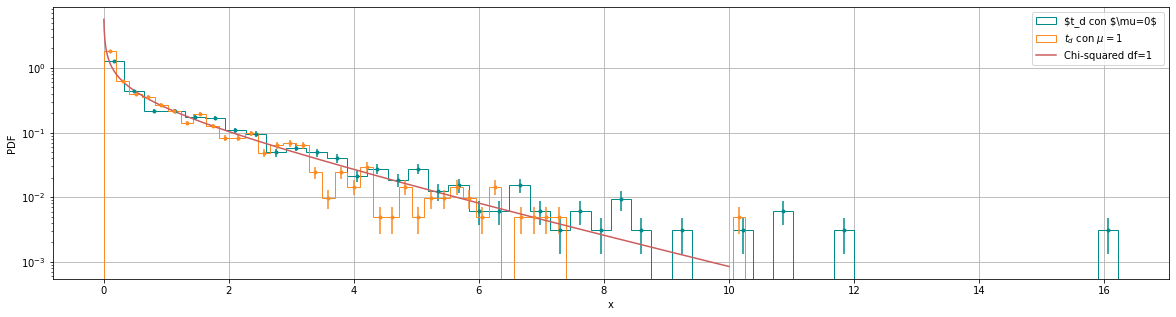

In [5]:
N = 1000
M = 20
emin = 0
emax = 50
lamb = 0.1
nbins = 10
tau = emax/emax


m, n = datos_e_histogramas(N, M, emin, emax, lamb, nbins) #off / on
s = sm(M, emin, emax, lamb, nbins) #del modelo
ctes = s, m, n, tau

#optimizo función de mu y de theta (denominador)
initial_guess = [1, 100]  
bounds = ((1e-10, 100), (1e-5, 1000))  # Límite inferior y superior para mu y theta respectivamente
result = minimize(mlnL2, initial_guess, args=(n, m, s, tau), bounds=bounds)
mu_hat, theta_hat = result.x
print("Optimización del denominador:")
print("Valor óptimo de mu:", round(mu_hat,3))
print("Valor óptimo de theta:", round(theta_hat,3))
print("Valor óptimo de Log Likehood", round(lnL(mu_hat,theta_hat,n,m,s, tau),3))
print('')

#optimizo función de theta (numerador)
initial_guess = [100]  
mu=mu_hat
result = minimize(mlnL1, initial_guess, args=(mu, n, m, s, tau))
theta_hat_hat = result.x
print("Optimización del numerador:")
print(f"Valor óptimo de theta para mu = {mu}:", round(theta_hat_hat[0],3))
print("Valor óptimo de Log Likehood", round(lnL(mu,theta_hat_hat,n,m,s, tau)[0],3))

#hago simulación del estadístico
Nsamp = 1000 #cantidad de veces que voy a simular
mu_0 = 0
mu_1 = 1
t_dist_0 = construir_estadistico(N, nbins, emin, emax, M, lamb, tau, Nsamp, mu_0)
t_dist_1 = construir_estadistico(N, nbins, emin, emax, M, lamb, tau, Nsamp, mu_1)


plt.figure(figsize=(20, 5))
binNum=50
histt_0 = plt.hist(t_dist_0, bins=binNum, density=True, label=f'$t_d con $\mu=0$ ', histtype='step', color=colors[0])
binCenter = 0.5 * (histt_0[1][1:] + histt_0[1][:-1]) 
plt.errorbar(binCenter,histt_0[0],yerr=errores(histt_0[0],len(t_dist_0)), fmt='.', color=colors[0])

histt_1 = plt.hist(t_dist_1, bins=binNum, density=True, label=f'$t_d$ con $\mu=1$ ', histtype='step', color=colors[2])
binCenter = 0.5 * (histt_1[1][1:] + histt_1[1][:-1]) 
plt.errorbar(binCenter,histt_1[0],yerr=errores(histt_1[0],len(t_dist_1)), fmt='.', color=colors[2])


x = np.linspace(0,10, 2000)  # Puedes ajustar el rango según tus necesidades, la ajusto a una chi2 de 1 gl
pdf = chi2.pdf(x, df=1)
plt.plot(x, pdf, label=f'Chi-squared df=1', color=colors[1])
plt.xlabel('x')
plt.ylabel('PDF')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Zoe\AppData\Local\Temp\ipykernel_17504\2496143617.py:2: RuntimeWarning: divide by zero encountered in log
  return k*np.log(mu)-gammaln(k + 1)-mu


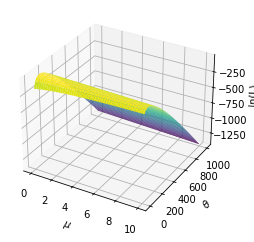

In [6]:
mu_array = np.linspace(0,10)
theta_array = np.linspace(0,1000)
mu_array, theta_array = np.meshgrid(mu_array, theta_array)
log_array = lnL(mu_array,theta_array,n,m,s,tau)
fig = plt.figure()

# Añadir un subplot 3D
ax = fig.add_subplot(111, projection='3d')

# Crear el gráfico de dispersión en 3D
surf=ax.plot_surface(mu_array, theta_array, log_array, cmap='viridis')

# Etiquetas de los ejes
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\theta$')
ax.set_zlabel(r'ln(L)')

# Mostrar el gráfico
#ax.view_init(elev=20, azim=30)
# Función de inicialización
def init():
    return [surf]

def update(frame, surf, ax):
    # Actualizar los datos de la superficie
    z_new = lnL(mu_array, theta_array + frame, n, m, s, tau)
    surf.set_array(z_new.ravel())
    surf.set_facecolors(surf.to_rgba(z_new.ravel()))

# Crear la animación
animation = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), init_func=init, fargs=(surf, ax), interval=50, blit=False)

# Mostrar la animación
plt.show()

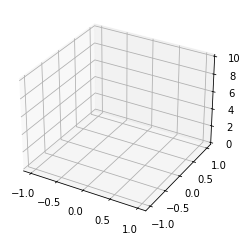

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# Configurar el modo notebook para animaciones interactivas


# Crear datos para el gráfico
t = np.linspace(0, 10, 100)
x = np.sin(t)
y = np.cos(t)
z = t

# Crear la figura y el eje 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Crear la línea que se animará
line, = ax.plot(x, y, z, label='Trayectoria', color='b')

# Función de inicialización para la animación
def init():
    line.set_data([], [])
    line.set_3d_properties([])
    return line,

# Función de actualización para la animación
def update(frame):
    line.set_data(x[:frame], y[:frame])
    line.set_3d_properties(z[:frame])
    return line,

# Configuración de la animación
ani = FuncAnimation(fig, update, frames=len(t), init_func=init, blit=True)

# Mostrar la animación y asignarla a una variable
animation_variable = plt.show()


Calculo el denominador

In [8]:
def calculate_log_L_den(ctes_val):
    s, m, n, tau = ctes_val
    initial_guess = [1, 100]
    bounds = [(0, 10), (0.0000001, 1000)]  # Adjust as needed
    objetivo_parcial = partial(log_likelihood_conjunta, ctes=[s, m, n, tau])
    result = minimize(objetivo_parcial, initial_guess, bounds=bounds) #falta agregar un parametro

    if result.success:
        optimal_mu, optimal_theta = result.x
        #print("Optimal mu:", optimal_mu)
        #print("Optimal theta:", optimal_theta)
        #print("Optimal value of the log-likelihood:", result.fun)
        #print(result.fun, optimal_mu, optimal_theta)
        return result.fun, optimal_mu, optimal_theta
    else:
        print("Optimization failed:", result.message)
        return result.message
    


Calculo el numerador

In [9]:
def log_likelihood_conjunta2(var, ctes): #pasar como tupla de parametros y ctes
    theta = var
    s, n, m, tau, mu = ctes 
    N = np.size(n)
    ln_total = 0
    for j in range(N):
        nu_1 = mu*s[j]+theta
        nu_2 = tau*theta
        ln_total += log_likelihood(nu_1, n[j])+log_likelihood(nu_2, m[j])
    return(-1*ln_total)


def calculate_log_L_num(mu_barrido, ctes):
    s, n, m, tau = ctes
    #mu_barrido=[optimal_mu] #chequeo y funciona
    #print(mu_barrido)
    mus = np.array([])
    thetas = np.array([])
    L_num = np.array([])
    for i in mu_barrido:
        initial_guess = [100]
        bounds = [(0.0000001, 1000)]  # Adjust as needed
        objetivo_parcial = partial(log_likelihood_conjunta2, ctes=[s, n, m, tau, i])
        result = minimize(objetivo_parcial, initial_guess, bounds=bounds) #falta agregar un parametro

        if result.success:
            thetas = np.append(thetas, result.x)
            L_num = np.append(L_num, result.fun)
            mus = np.append(mus, i)
            #print("Optimal theta:", optimal_theta)
            #print("Optimal value of the log-likelihood:", result.fun)
        #else:
            #print("Optimization failed:", result.message) #falla dos veces
    
    return L_num, thetas, mus

def calculate_log_L_num2(mu, ctes):
    s, n, m, tau = ctes
    initial_guess = [100]
    bounds = [(0.0000001, 1000)]  # Adjust as needed
    objetivo_parcial = partial(log_likelihood_conjunta2, ctes=[s, n, m, tau, mu])
    result = minimize(objetivo_parcial, initial_guess, bounds=bounds) #falta agregar un parametro
    try:
        if result.success:
            thetas = result.x
            L_num = result.fun
            return L_num, thetas
    except:
        pass
    

In [10]:
def MLE(params):
  tvar = np.linspace(0,1000,10) #Hago variar numéricamente el parámetro t para hallar el maximo de la funcion
  log_q2_tvar_i= np.array([])
  for i in range(len(tvar)):
      l_q2 = log_likelihood_conjunta2(tvar[i],params)
      log_q2_tvar_i=np.append(log_q2_tvar_i,l_q2)

  indice = np.argmax(log_q2_tvar_i)
  theta_max = tvar[indice]
  return(theta_max)


Calculo el t

In [11]:
def calculate_t(ctes, mu_barrido):
    log_L_den, optimal_mu, optimal_theta = calculate_log_L_den(ctes)

    
    log_L_num = calculate_log_L_num(mu_barrido, ctes)[0]
    mu = calculate_log_L_num(mu_barrido, ctes)[2]
    t = -2*(log_L_num-log_L_den)
    

    plt.scatter(mu, t, color=colors[1])
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"t")
    #print('Estadístico t:',t)
    #plt.legend()
    plt.show()

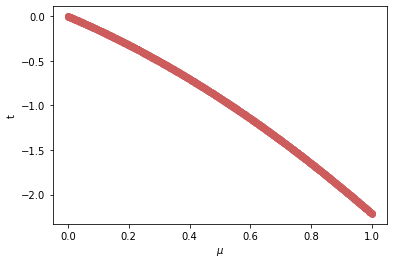

In [12]:
mu_barrido = np.linspace(1e-6,1,1000)
calculate_t(ctes, mu_barrido)

## Punto 7

In [13]:
def calculate_t_fixing_mu(ctes, mu):
    log_L_den, optimal_mu, optimal_theta = calculate_log_L_den(ctes)
    log_L_num = calculate_log_L_num2(mu, ctes)
    #print(log_L_den, log_L_num)
    t = 2*(log_L_num-log_L_den)
    return t
    

In [14]:
m, n = datos_e_histogramas(N,M)
s = sm(M)
tau = 1
mu = 1
ctes = s, m, n, tau

#mu_hat = calculate_log_L_den(ctes)[1]
#num = calculate_log_L_num2(1, ctes)
t = calculate_t_fixing_mu(ctes, mu)
#print(t)


TypeError: datos_e_histogramas() missing 4 required positional arguments: 'emin', 'emax', 'lamb', and 'nbins'

  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 7/1000 [00:00<00:31, 31.31it/s]

Optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH


  2%|▏         | 16/1000 [00:00<00:26, 36.69it/s]

Optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH


  4%|▍         | 42/1000 [00:01<00:27, 35.36it/s]

Optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH


 10%|▉         | 99/1000 [00:02<00:25, 35.48it/s]

Optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH


 11%|█▏        | 113/1000 [00:03<00:24, 35.98it/s]

Optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH


 16%|█▌        | 162/1000 [00:04<00:21, 38.36it/s]

Optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH


 18%|█▊        | 176/1000 [00:04<00:21, 37.80it/s]

Optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH


 56%|█████▋    | 565/1000 [00:15<00:10, 43.48it/s]

Optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH


 58%|█████▊    | 580/1000 [00:15<00:09, 42.44it/s]

Optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH


 77%|███████▋  | 768/1000 [00:20<00:05, 42.89it/s]

Optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH


 98%|█████████▊| 983/1000 [00:26<00:00, 39.83it/s]

Optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH


100%|██████████| 1000/1000 [00:26<00:00, 37.67it/s]


(array([7.41862954e-02, 5.49528114e-04, 7.85040163e-05, 1.57008033e-04,
        1.64858434e-03, 7.06536147e-03, 1.46802510e-02, 2.51997892e-02,
        2.11175804e-02, 4.78874499e-03]),
 array([-1.76341359e-07,  6.69023185e+00,  1.33804639e+01,  2.00706959e+01,
         2.67609279e+01,  3.34511600e+01,  4.01413920e+01,  4.68316240e+01,
         5.35218560e+01,  6.02120881e+01,  6.69023201e+01]),
 <BarContainer object of 10 artists>)

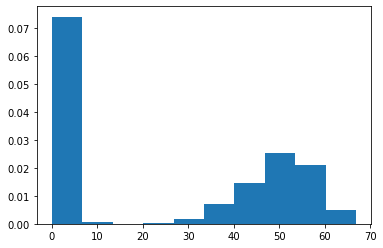

In [ ]:
def montecarlo_t(mu):
    tau = 1
    m, n = datos_e_histogramas(N,M)
    s = sm(M)
    params = s, n, m, tau
    t = calculate_t_fixing_mu(params, mu)
    return(t)
    
    
    
  
valores_t = np.array([])    
for i in tqdm(range(0,1000)):
    try:
        t = montecarlo_t(0)
        if t is not None:
            valores_t = np.append(valores_t, t)
    except:
        pass
    

#print(valores_t)
plt.hist(valores_t, density=True)    